In [1]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from pandas.plotting import scatter_matrix
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 1. Regression Neural Network

In this notebook we try to predict the median value of owner-occupied homes in $1000's. This dataset was aquired from kaggle and you can find it here: https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data. The dataset contains 13 features, whereas we will delete one of them which is the proportion of blacks by town. We exclude this feature, due to its discriminatory nature and personally I don't want to use such features in any model. We will try to solve this problem by creating a neural network in PyTorch for a regression problem. 

## 1.1 Load Data

In [2]:
# Define filepath
file_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'housing')
file_name = 'data_housing.csv'

In [3]:
# Load csv data
df_housing = pd.read_csv(os.path.join(file_path, file_name), sep=',', encoding='utf-8')
df_housing = df_housing.drop('B', axis=1)

In [4]:
# Create features (X) and labels (y) 
X, y = df_housing.drop('MEDV', axis=1), df_housing[['MEDV']]

## 1.2 Train / Test / Validation Split

In [5]:
# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=X.RAD,
                                                    random_state=42)

In [6]:
# Create test and validation split
X_test, X_val, y_test, y_val = train_test_split(X_test,
                                                y_test,
                                                test_size=0.5,
                                                random_state=42)

## 1.3 Check Data

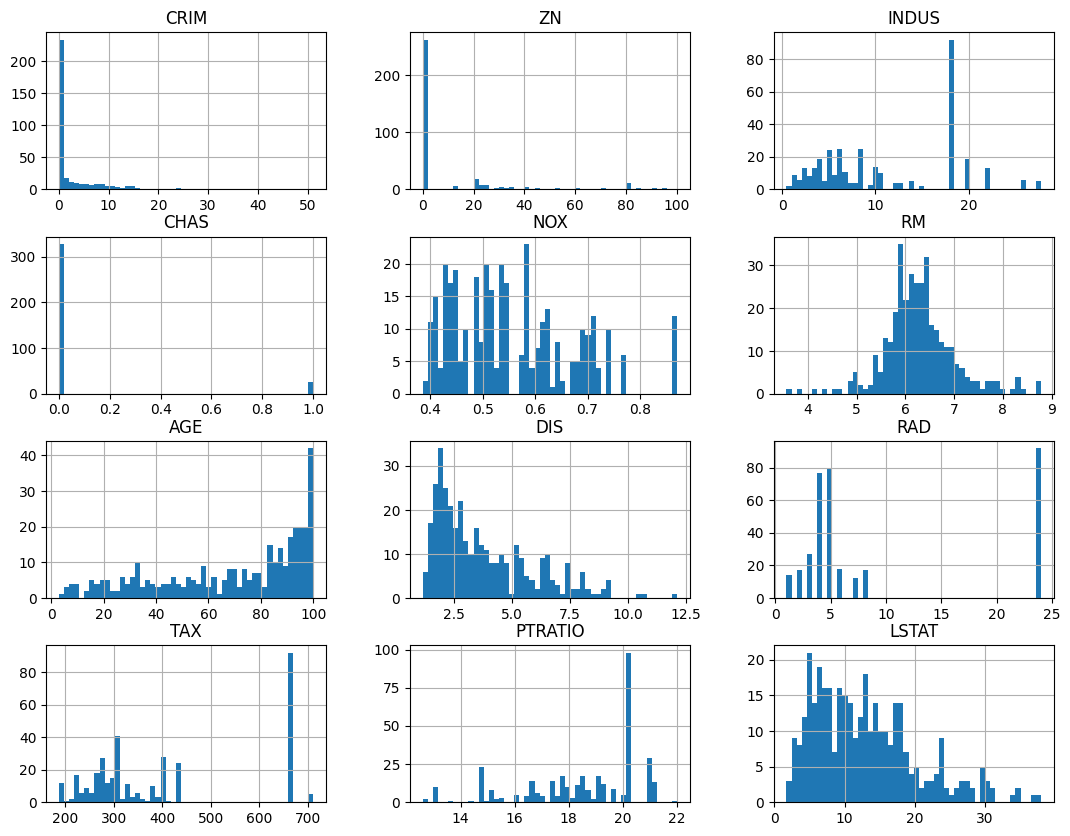

In [7]:
# Plot the distribution of the numerical variables
X_train.hist(bins=50, figsize=(13,10))
plt.show()

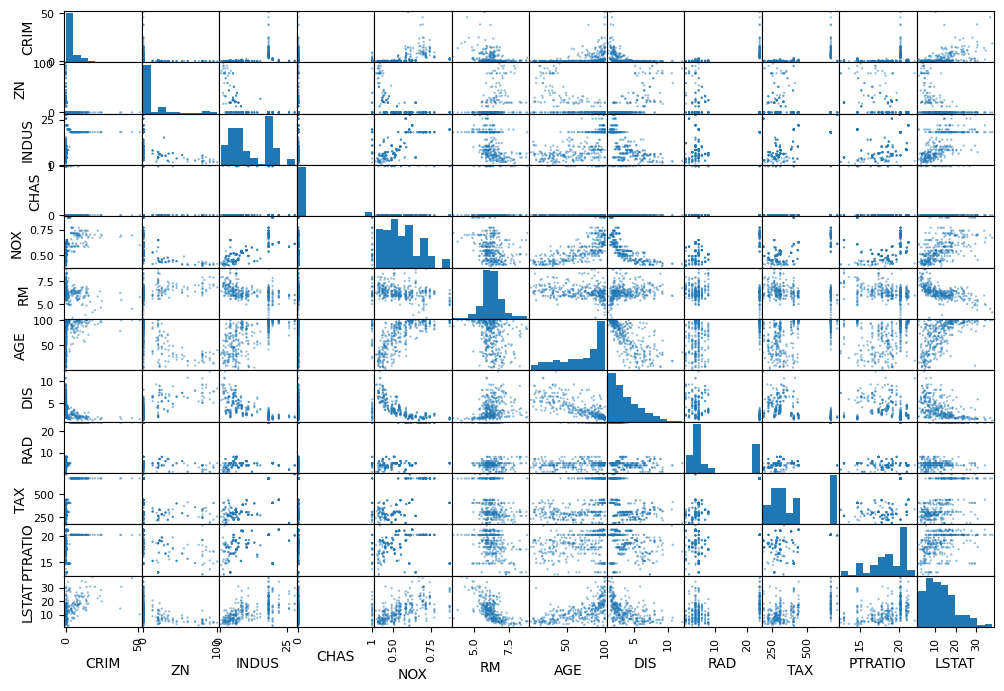

In [8]:
# Define the variables to check
attributes = X_train.columns
scatter_matrix(X_train[attributes], figsize=(12,8), s=10)
plt.show()

## 1.4 Data Pre-Processing

In [9]:
def data_preprocessing(data):
    
    # Create a copy of the data
    data_copy = data.copy()

    # Define numerical and categorical columns
    categorical_columns = ['RAD']
    numerical_columns_standard = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'LSTAT']

    # Pipeline for categorical features
    cat_pipeline = Pipeline(steps=[
        ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore')),
    ])

    # Pipeline for standard numerical features
    num_pipeline_standard = Pipeline(steps=[
        ('scale', StandardScaler())
    ])

    # Create column transformer
    col_trans = ColumnTransformer(transformers=[
        ('cat_pipeline', cat_pipeline, categorical_columns),
        ('num_pipeline_standard', num_pipeline_standard, numerical_columns_standard)
    ],
        remainder='passthrough',
        n_jobs=-1)
    
    # Fit and transform the data
    transformed_data = col_trans.fit_transform(data_copy)

    # Get the column names after transformation
    transformed_column_names = col_trans.get_feature_names_out()

    # Return both the transformed data and the column names
    return transformed_data, transformed_column_names

In [10]:
# Transform the different features from training, test and validation dataset
X_train, X_train_names = data_preprocessing(data=X_train)
X_test, X_test_names = data_preprocessing(data=X_test)
X_val, X_val_names = data_preprocessing(data=X_val)

In [11]:
# Transform labels to tensors as well
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

## 1.5 Create Dataset / DataLoader

In [12]:
class BostonDataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = torch.from_numpy(X)
    self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [13]:
# Prepare training, test and validation data
train_dataset = BostonDataset(X=X_train, y=y_train)
test_dataset = BostonDataset(X=X_test, y=y_test)
val_dataset = BostonDataset(X=X_val, y=y_val)

In [14]:
# Create train, test and validation loader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)

## 1.6 Build Model

In [15]:
# 1. Construct a model that subclasses nn.Module
class HousingModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # 2. Create 3 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=input_size, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # Non Linear Activation Function
        
    # 3. Define forward method that outlines the forward pass
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

In [16]:
# Initialize the MLP model
model = HousingModel(input_size=X_train.shape[1]) 

# Define the loss function and optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

c:\Users\lukas\anaconda3\envs\pytorch_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.7 Train the Model

In [17]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    
    # Create random seed
    torch.manual_seed(42)
    # Create an empty list to store metrics for each epoch
    metrics = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.float())
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        
        # Calculate average training loss for the epoch
        train_loss = running_train_loss / len(train_loader.dataset)
        
        # Evaluate on validation set
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_outputs = model(val_inputs.float())
                val_loss = criterion(val_outputs, val_targets.float())
                running_val_loss += val_loss.item() * val_inputs.size(0)
        
        # Calculate average validation loss for the epoch
        val_loss = running_val_loss / len(val_loader.dataset)

        # Append epoch, training loss, and validation loss to metrics list
        metrics.append({'Epoch': epoch+1,
                        'Train Loss': train_loss,
                        'Validation Loss': val_loss})

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")

    # Convert metrics list to DataFrame
    df_metrics = pd.DataFrame(metrics)
    
    return df_metrics

In [18]:
# Train the model
df_metrics = train_model(model, trainloader, val_loader, loss_function, optimizer, num_epochs=20)

Epoch 1/20 | Train Loss: 21.9893 | Validation Loss: 23.1967
Epoch 2/20 | Train Loss: 21.1768 | Validation Loss: 21.4998
Epoch 3/20 | Train Loss: 18.1018 | Validation Loss: 16.9881
Epoch 4/20 | Train Loss: 13.0765 | Validation Loss: 11.1042
Epoch 5/20 | Train Loss: 7.2051 | Validation Loss: 5.6059
Epoch 6/20 | Train Loss: 4.7257 | Validation Loss: 5.0497
Epoch 7/20 | Train Loss: 3.5201 | Validation Loss: 3.8263
Epoch 8/20 | Train Loss: 3.2388 | Validation Loss: 4.0077
Epoch 9/20 | Train Loss: 2.9977 | Validation Loss: 3.7273
Epoch 10/20 | Train Loss: 2.8720 | Validation Loss: 3.4221
Epoch 11/20 | Train Loss: 2.9433 | Validation Loss: 4.0438
Epoch 12/20 | Train Loss: 2.8665 | Validation Loss: 3.2035
Epoch 13/20 | Train Loss: 2.8339 | Validation Loss: 3.7530
Epoch 14/20 | Train Loss: 2.7258 | Validation Loss: 3.3767
Epoch 15/20 | Train Loss: 2.5648 | Validation Loss: 3.5241
Epoch 16/20 | Train Loss: 2.6037 | Validation Loss: 2.9750
Epoch 17/20 | Train Loss: 2.4937 | Validation Loss: 3.923

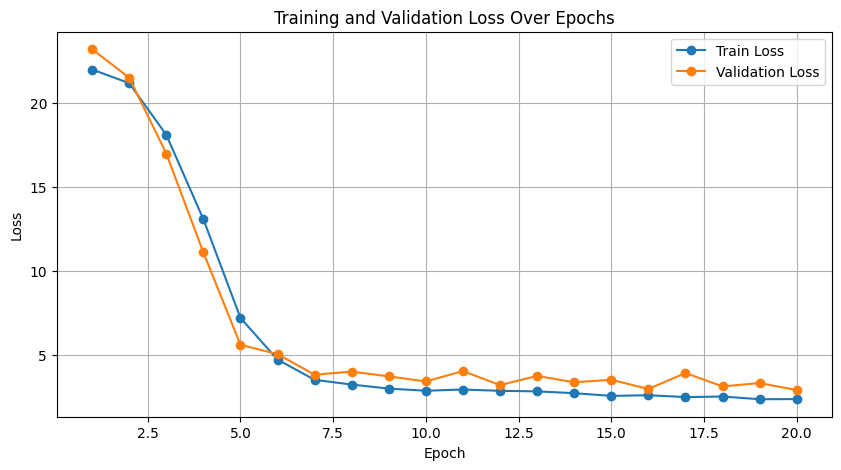

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(df_metrics['Epoch'], df_metrics['Train Loss'], label='Train Loss', marker='o')
ax.plot(df_metrics['Epoch'], df_metrics['Validation Loss'], label='Validation Loss', marker='o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss Over Epochs')
ax.legend()
ax.grid()
plt.show()

## 1.8 Evaluate Model on Test-Set

In [30]:
# Evaluation function
def evaluate_model(model, data_loader, criterion):
    
    predictions = []
    actuals = []
    running_loss = 0.0

    model.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.float())
            running_loss += loss.item() * inputs.size(0)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(targets.squeeze().tolist())
    
    avg_loss = running_loss / len(data_loader.dataset)

    return actuals, predictions, avg_loss

In [32]:
# Evaluate on test set
actuals, predictions, avg_loss = evaluate_model(model, test_loader, loss_function)
print(f"Test Loss: {avg_loss:.4f}")

Test Loss: 3.4950


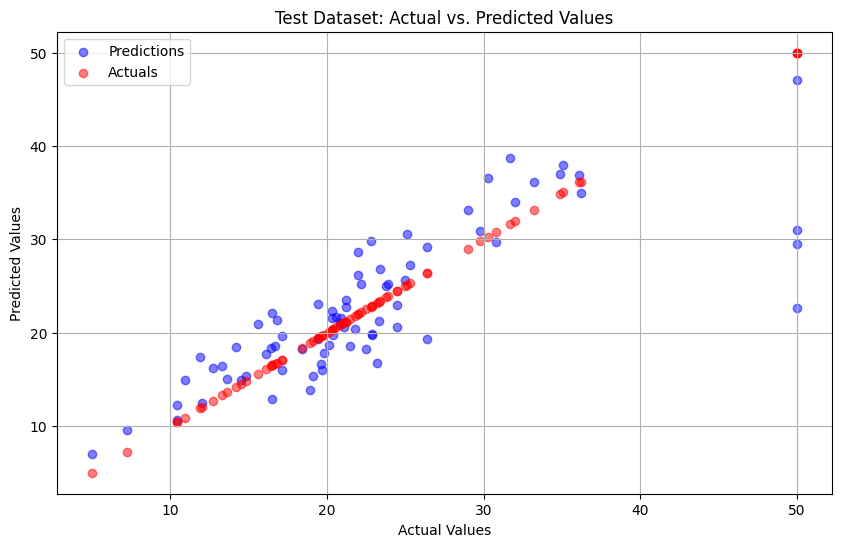

In [38]:
# Plot actual vs. predicted values
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(actuals, predictions, color='blue', alpha=0.5, label='Predictions')
ax.scatter(actuals, actuals, color='red', alpha=0.5, label='Actuals')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Test Dataset: Actual vs. Predicted Values')
ax.legend()
ax.grid(True)
plt.show()